# Pseudo Labeling

## Set up

In [ ]:
import os
import json
import pickle
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import seaborn as sns

PATH = Path.cwd().parents[2]

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(PATH))

from scripts.feature_extractions.tf_idf import extract_tf_idf_for_unlabeled
from scripts.feature_extractions.n_grams import extract_n_grams_for_unlabeled


In [2]:
MODEL_PATH = os.path.join(PATH, 'models/1_groundtruth_with_large')
DATA_PATH = os.path.join(PATH, 'data')
BASE_PATH  = os.path.join(DATA_PATH, 'external/crpwarner')
MERGE_PATH = os.path.join(BASE_PATH, 'merged')
LARGE_PATH = os.path.join(BASE_PATH, 'large')
SAVE_PATH = os.path.join(DATA_PATH, 'interim/crpwarner/pseudo-label')

In [3]:
mint_df = pd.read_csv(os.path.join(MERGE_PATH, 'mint.csv')).set_index('address')
leak_df = pd.read_csv(os.path.join(MERGE_PATH, 'leak.csv')).set_index('address')
limit_df = pd.read_csv(os.path.join(MERGE_PATH, 'limit.csv')).set_index('address')

sol_path_list = list(Path(os.path.join(LARGE_PATH, 'sol')).glob('*.sol'))
hex_path_list = list(Path(os.path.join(LARGE_PATH, 'hex')).glob('*.hex'))

data = {
  'mint': mint_df.index,
  'leak': leak_df.index,
  'limit': limit_df.index
}

## Mint

### Load Model

In [4]:
name = 'mint'

In [5]:
model = pickle.load(open(list(Path(MODEL_PATH).glob(f'{name}-*.pkl'))[0], 'rb'))

In [6]:
with open(list(Path(MODEL_PATH).glob(f'{name}-*.json'))[0], 'r', encoding='utf-8') as f:
    feature_cols = json.load(f)

In [7]:
feature_cols[:5]

['spdx', 'license', 'identifier', 'mit', 'pragma']

### Labelling

In [8]:
records = []

for sol_path in tqdm(sol_path_list, desc='labelling'):
    address = sol_path.stem
    record = dict()
    if address not in data[name]:
        record['address'] = address
        X = extract_tf_idf_for_unlabeled([sol_path], feature_cols)
        prob = model.predict_proba(X)
        record['TP?'] = model.predict(X)[0]
        record["confidence"] = prob.max(axis=1)[0]
        records.append(record)

pseudo_label_df = pd.DataFrame(records)
pseudo_label_df.head()

labelling: 100%|██████████| 13482/13482 [05:02<00:00, 44.63it/s]


,address,TP?,confidence
0,0x8810c63470d38639954c6b41aac545848c46484a,1,0.8
1,0x30df12e5f1f5b327e385f5f48736aff5a1e52103,1,0.8
2,0x49b84450a9a56081ce570920aa578c35e0b2461f,1,0.8
3,0xa46630a30a77d27607fc05b62da2ef291fc1460c,1,0.6
4,0xc22e162db0b8b55486160c35064f91e418cc2221,1,0.8


In [9]:
pseudo_label_df.describe()

,TP?,confidence
count,13390.000000,13390.000000
mean,0.949813,0.799149
std,0.218338,0.129146
min,0.000000,0.600000
25%,1.000000,0.800000
50%,1.000000,0.800000
75%,1.000000,0.800000
max,1.000000,1.000000


In [10]:
high_conf_df = pseudo_label_df[pseudo_label_df["confidence"] >= 0.85]
f"{len(high_conf_df)} high-confidence pseudo-labeled contracts"


'2763 high-confidence pseudo-labeled contracts'

<Axes: xlabel='TP?', ylabel='count'>

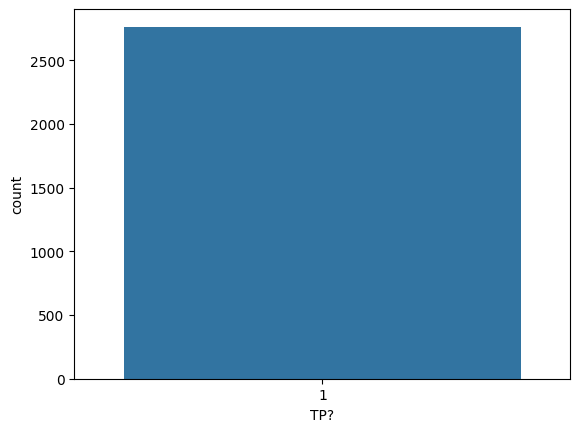

In [11]:
sns.countplot(x="TP?", data=high_conf_df)

### Save

In [12]:
high_conf_df.to_csv(os.path.join(SAVE_PATH, f'{name}.csv'), index=False)

## Leak

### Load Model

In [13]:
name = 'leak'

In [14]:
model = pickle.load(open(list(Path(MODEL_PATH).glob(f'{name}-*.pkl'))[0], 'rb'))

In [15]:
with open(list(Path(MODEL_PATH).glob(f'{name}-*.json'))[0], 'r', encoding='utf-8') as f:
    feature_cols = json.load(f)

In [16]:
feature_cols[:5]

['spdx', 'license', 'identifier', 'mit', 'pragma']

### Labelling

In [17]:
records = []

for sol_path in tqdm(sol_path_list, desc='labelling'):
    address = sol_path.stem
    record = dict()
    if address not in data[name]:
        record['address'] = address
        X = extract_tf_idf_for_unlabeled([sol_path], feature_cols)
        prob = model.predict_proba(X)
        record['TP?'] = model.predict(X)[0]
        record["confidence"] = prob.max(axis=1)[0]
        records.append(record)

pseudo_label_df = pd.DataFrame(records)
pseudo_label_df.head()

labelling: 100%|██████████| 13482/13482 [04:52<00:00, 46.03it/s]


,address,TP?,confidence
0,0x8810c63470d38639954c6b41aac545848c46484a,0,0.701847
1,0x30df12e5f1f5b327e385f5f48736aff5a1e52103,0,0.700461
2,0x49b84450a9a56081ce570920aa578c35e0b2461f,0,0.615060
3,0xa46630a30a77d27607fc05b62da2ef291fc1460c,0,0.607886
4,0xc22e162db0b8b55486160c35064f91e418cc2221,0,0.700461


In [18]:
pseudo_label_df.describe()

,TP?,confidence
count,13395.000000,13395.000000
mean,0.016648,0.690438
std,0.127953,0.057234
min,0.000000,0.501886
25%,0.000000,0.653107
50%,0.000000,0.700461
75%,0.000000,0.705647
max,1.000000,0.919945


In [19]:
# Pseudo leak = 1 (medium confidence)
leak_pos = pseudo_label_df[
    (pseudo_label_df["TP?"] == 1) &
    (pseudo_label_df["confidence"] >= 0.5) &
    (pseudo_label_df["confidence"] < 0.75)
]

# Pseudo leak = 0 (high confidence)
leak_neg = pseudo_label_df[
    (pseudo_label_df["TP?"] == 0) &
    (pseudo_label_df["confidence"] >= 0.8)
]

high_conf_df = pd.concat([leak_pos, leak_neg])
f"{len(high_conf_df)} high-confidence pseudo-labeled contracts"


'574 high-confidence pseudo-labeled contracts'

<Axes: xlabel='TP?', ylabel='count'>

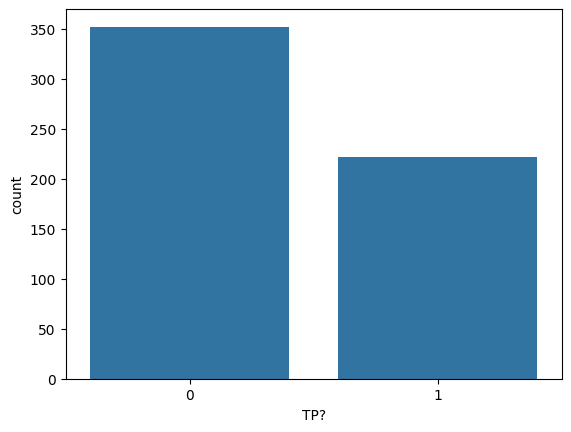

In [20]:
sns.countplot(x="TP?", data=high_conf_df)

### Save

In [21]:
high_conf_df.to_csv(os.path.join(SAVE_PATH, f'{name}.csv'), index=False)

## Limit

### Load Model

In [22]:
name = 'limit'

In [23]:
model = pickle.load(open(list(Path(MODEL_PATH).glob(f'{name}-*.pkl'))[0], 'rb'))

In [24]:
with open(list(Path(MODEL_PATH).glob(f'{name}-*.json'))[0], 'r', encoding='utf-8') as f:
    feature_cols = json.load(f)

In [25]:
feature_cols[:5]

['add add',
 'add and',
 'add and dup',
 'add calldataload',
 'add calldataload push']

### Labelling

In [26]:
records = []

for sol_path in tqdm(hex_path_list, desc='labelling'):
    address = sol_path.stem
    record = dict()
    if address not in data[name]:
        record['address'] = address
        X = extract_n_grams_for_unlabeled([sol_path], feature_cols)
        prob = model.predict_proba(X)
        record['TP?'] = model.predict(X)[0]
        record["confidence"] = prob.max(axis=1)[0]
        records.append(record)

pseudo_label_df = pd.DataFrame(records)
pseudo_label_df.head()

100%|██████████| 1/1 [00:00<00:00, 26.21it/s]
invalid instruction: PUSH28
100%|██████████| 1/1 [00:00<00:00, 27.39it/s]:15, 14.72it/s]
invalid instruction: PUSH30
100%|██████████| 1/1 [00:00<00:00, 27.83it/s]
invalid instruction: PUSH24
100%|██████████| 1/1 [00:00<00:00, 27.81it/s]8:32, 12.11it/s]
invalid instruction: PUSH27
100%|██████████| 1/1 [00:00<00:00, 24.34it/s]6:45, 13.39it/s]
invalid instruction: PUSH17
100%|██████████| 1/1 [00:00<00:00, 36.07it/s]
invalid instruction: PUSH17
100%|██████████| 1/1 [00:00<00:00, 30.77it/s]
invalid instruction: PUSH13
100%|██████████| 1/1 [00:00<00:00, 26.97it/s]
invalid instruction: PUSH28
100%|██████████| 1/1 [00:00<00:00, 29.77it/s]
invalid instruction: PUSH24
100%|██████████| 1/1 [00:00<00:00, 55.59it/s]
invalid instruction: PUSH11
100%|██████████| 1/1 [00:00<00:00,  7.02it/s]
invalid instruction: PUSH31
100%|██████████| 1/1 [00:00<00:00, 36.88it/s]5:58, 14.03it/s]
invalid instruction: PUSH29
100%|██████████| 1/1 [00:00<00:00, 55.05it/s]
inv

,address,TP?,confidence
0,0x71a982a028c9d4b0566041a78df12b810462e155,0,0.553261
1,0x9b11efcaaa1890f6ee52c6bb7cf8153ac5d74139,0,0.829765
2,0x9ec8d44af808d7cca2ec23c0dc0d1f49a3386ea4,1,0.894693
3,0x662abcad0b7f345ab7ffb1b1fbb9df7894f18e66,1,0.530554
4,0x21f15966e07a10554c364b988e91dab01d32794a,0,0.575254


In [27]:
pseudo_label_df.describe()

,TP?,confidence
count,13392.000000,13392.000000
mean,0.281511,0.729561
std,0.449753,0.124380
min,0.000000,0.500019
25%,0.000000,0.625415
50%,0.000000,0.737311
75%,1.000000,0.825397
max,1.000000,0.986025


In [28]:
high_conf_df = pseudo_label_df[pseudo_label_df["confidence"] >= 0.7]
f"{len(high_conf_df)} high-confidence pseudo-labeled contracts"


'7942 high-confidence pseudo-labeled contracts'

<Axes: xlabel='TP?', ylabel='count'>

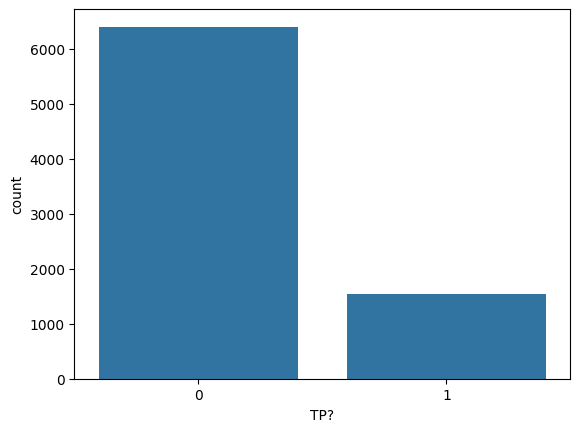

In [29]:
sns.countplot(x="TP?", data=high_conf_df)

### Save

In [30]:
high_conf_df.to_csv(os.path.join(SAVE_PATH, f'{name}.csv'), index=False)